<a href="https://colab.research.google.com/github/joseferbis-cell/PLs-ADFM/blob/main/practice_1_neural_network_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/vischia/adfm_2024-2025/blob/master/practice_1_neural_network_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regress the quality of a wine like a boss
## Write your own DNN in python

Copyright (c) Pietro Vischia, 2020-2025
algo debajo de copyright asdfasdfasdf

You will analyze the "Housing" dataset used in the first PAs, consisting in data on a set of houses in San Francisco and New York. The dataset is available through https://github.com/jadeyee/r2d3-part-1-data .

The goal is to classify houses as being New York or San Francisco houses.

Let's load the data, using the same commands as in the other notebooks: <


In [2]:
#import wget
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [4]:
!wget https://raw.githubusercontent.com/jadeyee/r2d3-part-1-data/refs/heads/master/part_1_data.csv

data = pd.read_csv("./part_1_data.csv", sep=",",skiprows=2)

data.head()


--2025-10-23 16:17:17--  https://raw.githubusercontent.com/jadeyee/r2d3-part-1-data/refs/heads/master/part_1_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15770 (15K) [text/plain]
Saving to: ‘part_1_data.csv.1’

part_1_data.csv.1   100%[===================>]  15.40K  --.-KB/s    in 0.001s  

2025-10-23 16:17:17 (17.7 MB/s) - ‘part_1_data.csv.1’ saved [15770/15770]



,in_sf,beds,bath,price,year_built,sqft,price_per_sqft,elevation
0,0,2.0,1.0,999000,1960,1000,999,10
1,0,2.0,2.0,2750000,2006,1418,1939,0
2,0,2.0,2.0,1350000,1900,2150,628,9
3,0,1.0,1.0,629000,1903,500,1258,9
4,0,0.0,1.0,439000,1930,500,878,10


In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


#data[data.columns] = scaler.fit_transform(data[data.columns])


for c in data.columns:
    data[c] = scaler.fit_transform(data[c].to_numpy().reshape(-1, 1))
data.head()




,in_sf,beds,bath,price,year_built,sqft,price_per_sqft,elevation
0,0.0,0.2,0.000000,0.029711,0.588235,0.092123,0.168321,0.042017
1,0.0,0.2,0.111111,0.093821,0.926471,0.147931,0.385361,0.000000
2,0.0,0.2,0.111111,0.042562,0.147059,0.245661,0.082660,0.037815
3,0.0,0.1,0.000000,0.016164,0.169118,0.025367,0.228123,0.037815
4,0.0,0.0,0.000000,0.009208,0.367647,0.025367,0.140383,0.042017


Let's split the data into a training and a test dataset

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.tree import export_graphviz
from sklearn.inspection import permutation_importance
try:
    # See #1137: this allows compatibility for scikit-learn >= 0.24
    from sklearn.utils import safe_indexing
except ImportError:
    from sklearn.utils import _safe_indexing


X = data.drop(["in_sf"], axis=1)
y = data["in_sf"]

import sklearn
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.33, random_state=42)

print(f"We have {len(X_train)} training samples with {sum(y_train)} signal and {sum(1-y_train)} background events")
print(f"We have {len(X_test)} testing samples with {sum(y_test)} signal and {sum(1-y_test)} background events")


We have 329 training samples with 184.0 signal and 145.0 background events
We have 163 testing samples with 84.0 signal and 79.0 background events


Now that we have our dataset ready, it's time to...

## Code a neural network from scratch

#### Details on neural networks

Biology teaches us that the brain is constituted of neurons and connections between them: the synapses.
By comparing the brain of various animals, we now think that the more the number of neurons and most importantly of synapses is large, the more complex are the functions that the brain can execute.

Let's learn the inner workings of a very simplified mathematical model of brain: an artificual neural network.

The first element is the neuron. The simplest model (and one of the first) we have is the [*perceptron*](https://en.wikipedia.org/wiki/Perceptron). The neuron is modelled by a mathematical function that takes some arguments as inputs, combines them linearly, and returns an output value.
We denote as *weights* the coefficients of the linear combination.

However, we want to be able to approximate nonlinear functions, so we need to plug in a degree of nonlinearity inside the neuron, and we want the neuron to fire only when a certain threshold in the output is reached (a certain amount of stimulation).

We modify the output of the neuron by an activation function $f_{act}$: the neuron is activated if the activation function returns a non-zero value. The output of the neuron is defined as:

$$
y_n = f_{act}(\sum_i w_{i,n} x_{i,n})
$$

If the activation function is not linear, we are happy because we have obtained a neuron that gives a nonlinear output and gets activated only if the stimuli it receives are large enough.

You will use in this exercise two activation functions:

- [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)), a function $f(x)$ that returns 0 if $x<0$, and $x$ otherwise. It is used to introduce a nonlinearity while allowing the variable to have a wide range of values;
- [sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function), a function that rescales any number into a number between 0 and 1. It is often used in classification contexts as the activation function for the output layer, to be able to interpret outputs as probabilities.

Here you have a graphical representation of the perceptron, by [https://towardsdatascience.com](https://towardsdatascience.com):

![neuron](https://miro.medium.com/max/1435/1*n6sJ4yZQzwKL9wnF5wnVNg.png "Figure from https://towardsdatascience.com")

Now we have to connect the neurons. The simplest way is to build layers of neurons, and to connect all neurons of consecutive layers. Starting with the inputs, there is a first layer of neurons. Each neuron combines linearly the inputs and passes the result through activation function to give an output value. The set of outputs of a layer will be the input of the following layer:

![neuralnet](https://upload.wikimedia.org/wikipedia/commons/thumb/4/46/Colored_neural_network.svg/800px-Colored_neural_network.svg.png "Figure from wikipedia")

A neural network is characterized by a set of weights assigned to the connections that define the structure of the network. You can see this as a mathematical function with many free parameters (the weights) that takes the inputs and gives an output. The problem of learning is then the problem of finding the values of the free parameters that minimize the difference between the output and the target distribution that we want to learn.

#### The loss function

For regression problems, the loss function is typically the Mean Square Error (MSE).

For classification problems, the loss function is typically the *binary cross entropy*, defined for one data point $i$ as:

$$
Loss_i = -( y_{true}log(\hat{y}) + (1-y_{true})log(1-\hat{y}) )
$$

ATTENTION: if $\hat{y}$ is either 0 or 1, the log is undefined. You can add a workaround by putting log(0) to minus infinity, e.g., if $\hat{y}$ is defined as $yhat$, `(-10^8 if (yhat==0 or yhat==1) else np.log(yhat) )`


#### The training process

Schematically, the training process consists in:

- for each epoch
   * for each training set data point:
      1. calculate the output of each neuron, starting from the inputs to the output
      2. compare the output of the last neuron with the reference wine quality
      3. propagate the error back towards the inputs, without updating the weights (the error needs to be propagated with respect to the current values of the weights)
      4. update all the weights
      5. save the value of the loss function for each event
   * for each test set data point:
      1. save the value of the loss function for each event
   * aggregate the loss function by computing an average
      1. For the training dataset, this is the average training loss
      2. For the test dataset, this is the average validation loss (you see here I am using validation and test indifferently)

The idea is the training will stop when the loss function doesn't improve anymore (it remains stationary at its minimum. If the training loss keeps diminishing and the test loss begins increasing, then we might be starting to learn statistical fluctuations of the training dataset.


#### Clarification on the connections between networks (to fix ideas)

If the network has the following structure: (input layer: two inputs `A` et `B`;  first internal (_hidden_) layer: two neurons `1a` et `1b`; second hidden layer: two neurons `2a` et `2b`; output `y`), the list of connections (the weights) is:

- Four weights connecting the inputs to the layer 1:
    - `wA1a` (connects input `A` to neuron `1a`)
    - `wA1b` (connects input `A` to neuron `1b`)
    - `wB1a` (connects input `B` to neuron `1a`)
    - `wB1b` (connects input `B` to neuron `1b`)
- Four weights connecting the neurons of layer 1 to those of layer 2:_
    - `W1a2a` (connects neuron `1a` to neuron `2a`)
    - `W1a2b` (connects neuron `1a` to neuron `2b`)
    - `W1b2a` (connects neuron `1b` to neuron `2a`)
    - `W1b2b` (connects neuron `1b` to neuron `2b`)
- Two weights connecting the neurons of layer 2 to the output y:
    - `W2ay` (connects neuron `2a` to output `y`)
    - `W2by` (connects neuron `2b` to output `y`)

####  Backpropagation

To perform backpropagation we need, for each neuron, to propagate back the error of the neurons of the following layer (so you need to go backwards). We use the chain rule.

- Error for a neuron of the output layer:

$$
\epsilon = (y_{true} - \hat{y}) * activation\_derivative(\hat{y})
$$

Here $\hat{y}$ is the output of this output neuron, and $y_{true}$ is the target quality of the wine

- Error for a neuron $m$ of an internal layer $N$:

$$
\epsilon_{m, N} = \sum_{k} (w_{k, N+1} * \epsilon_{k, N+1}) * activation\_derivative(\hat{m})
$$

Here, $\epsilon_{k,N+1}$ is the error of the neuron $k$ of the following layer (layer $N+1$), $w_{k, N+1}$ is the weight of the connection between the neuron $m$ and the neuron $k$ of the next layer, and $\hat{m}$ is the output of neuron $m$


#### Updating the weights

After having backpropagated all the gradient, you have to update all the weights using this formula:

$$
w = w + learning\_rate * error * input
$$

Ici $error$ is the error calculated via backpropagation, $input$ is the input value of the neuron that had been originally passed to the neuron, and $learning rate$ is a parameter governing how fast we climb down the gradient.


#### At the end of each epoch

To check for convergence of the network, a standard practice is to aggregate the errors $\hat{y} - y_{true}$  of all the events at the end of each epoch, in order to reduce the sensitivity to statistical fluctuations in the training sample. The first pillar of statistical wisdom according to Stigler is precisely aggregation.

For regression problems, in analogy with $\chi^2$ fit, we can for example calculate the $MSE = \frac{1}{N} \sum_{events} (\hat{y}-y_{true})^2$ and plot the MSE as a function of the number of epochs. If the network is improving its predictions, we should see something like this:

![mse](https://cern.ch/vischia/mse_pythonCourse.png "Figure by Pietro Vischia, 2019")

For classification problems, the figure of merit is typically the accuracy, defined as:

$$
Accuracy = \frac{TruePositives + TrueNegatives}{TruePositives+TrueNegatives+FalsePositives+FalseNegatives}\,.
$$

*HINT*: you can calculate these quantities easily from the confusion matrix.


#### Diagnostic plots

- 1) Average loss as a function of the epoch
- 2a) Regression: histogram of $\frac{\hat{y} - y_{true}}{y_{true}}$
- 2b) Regression: histogram of $\frac{\hat{y} - y_{true}}{y_{true}}$ as a function of $y_{true}$
- 3a) Classification: confusion matrix
- 3b) Classification: ROC curve

### Weights initialization
- To initialize the weights at the beginning you can use a Gaussian, or a truncated gaussian ( (scipy.stats.truncnorm), or a $random uniform[0,1]$


### Which gradient descent scheme should you check?

All three :D

The code should take as an input the scheme: `stochastic`, `batch`, `minibatch`. For `minibatch`, an additional parameter should be taken as an input, i.e. the number of events per batch.

- `stochastic`: the event weights are updated after backpropagating each data point. One epoch corresponds to having iterated through all training events (i.e. one epoch corresponds to $N_{train}$ weight updates)
- `batch`: the event weights are updated only after all training events have been processed. One epoch corresponds to having iterated through all training events (i.e. one epoch corresponds to $1$ weight update)
- `minibatch`: a relatively small number of events (a batch) is sampled each time, and weights are updated after every batch (one epoch is defined as $N_{train}/batchSize$ iterations)

---

Let's now start with the elements we need.

First, we need to realize that although we could in principle model the problem in an object-oriented way, that is define a class `Neuron` and have a class `Network` that collects neurons maybe into instances of a class `Layer`, this doesn't exploit the synthetical concepts behind representing neural network operations in a backgpropagation-friendly way.

In other words, the simplest way we can encode the problem is to have in our mind the neural structure as a set of neurons with connections, and write instead in the code the problem as a set of weights that must be combined in ways defined by the neurons.

This highlights the fact that the neuron outputs are transient: the real parameters of the network, that we must store for learning and later use, are the weights.

All of this to say that we will just store appropriately-sized matrices of weights, and the neurons wil "exist" as operations of matrix multiplication between the weights matrices.

To make matrix multiplication we will use `np.dot`.

The exact implementation is courtesy https://www.analyticsvidhya.com/blog/2020/07/neural-networks-from-scratch-in-python-and-r/

In [7]:
# a: 2x3
a=[
    [2,2,3],
    [2,2,3]
]
# b: 3x4
b=[
   [1,2,3,4],
   [1,2,3,4],
   [1,2,3,4]
]

# a dot b: 2x4

print(np.dot(a,b))

[[ 7 14 21 28]
 [ 7 14 21 28]]


Next we need to write our activation function and its derivative.

Let's implement the sigmoid (we will use it for the output layer).
You can also implement the ReLU if you wish.


In [18]:
def sigmoid(input):
    return  1/(1+np.exp(-input))

# Define the sigmoid derivative function
def sigmoid_derivative(input):
    return sigmoid(input)*(1-sigmoid(input))

# Definimos relu ya que estamos

def relu(input):
  return np.maximum(0,input)

def relu_derivative(input):
  return np.where(input>0,1,0)


Let's plot both

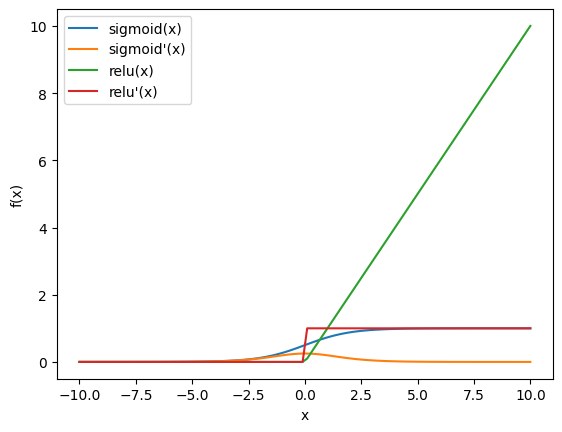

In [19]:
x=np.linspace(-10,10,100)

plt.plot(x, sigmoid(x), label='sigmoid(x)')
plt.plot(x, sigmoid_derivative(x), label='sigmoid\'(x)')
plt.plot(x, relu(x), label='relu(x)')
plt.plot(x, relu_derivative(x), label='relu\'(x)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend(loc='best')

The activation function become larger than 0.5 at $x=0$. We need to include the possibility of shifting the value for which the neuron activates. This is done by introducing a bias.

The neuron output from

$$
y = f(\sum(w_i x_i))
$$

(that activates for $\sum(w_i x_i)>0$) will be

$$
y = f(\sum(w_i x_i+ w_bb) )
$$

that activates at a learnable ($w_b$) value.


Now we need to define what's the structure of the network.

Let's assume we have one input layer,  one hidden layer, and one output layer. We now define the number of neurons per each layer. You can generalize to an array of hidden layers.

In [32]:
n_inputs = X_train.shape[1]
n_hidden = 20
n_output = 1

print(f"n_inputs: características:{n_inputs}")
print(f"n_hidden: neuronas ocultas:{n_hidden}")
print(f"n_output: salidas:{n_output}")


n_inputs: características:7
n_hidden: neuronas ocultas:20
n_output: salidas:1


We now have to create the arrays for the weights and initialize the weights to a starting value, for the first forward pass. The weights will be later updated.

Remember to set appropriate sizes to account for the dot products.

You can later try to see what changes in the training when initializing e.g. with gaussian weights.

Let's also disregard the bias :D

Now we need to implement the forward pass, for each layer transition.

We can also print out what happens for an untrained forward pass, and the MSE

Now we need to implement the backpropagation algorithm. We start with the rate of change of the output error

In [ ]:
error =


Now, let's proceed through the layers

Now we can update the weights

Now we have described fully the process.

Let's put it together in a loop!

In [ ]:
plt.plot(losses)